In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.python.client import device_lib
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.ndimage import rotate
from skimage.transform import resize
import os
import PIL
from tensorflow.keras import layers
from astropy import stats
import time
from IPython import display
import sys
from tqdm import tqdm

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
images = np.load('sim_filaments.npy', allow_pickle = True)

In [10]:
sigma = 1
for i in range(len(images)):
    mean, median, std = stats.sigma_clipped_stats(images[i], sigma=sigma)
    images[i][images[i] < median+sigma*std] = median+sigma*std

In [11]:
for i in range(len(images)):
    images[i] = 2*(images[i]-np.min(images[i]))/np.ptp(images[i])-1

In [12]:
np.save('sim_ganimages.npy', images)

In [13]:
images = np.load('sim_ganimages.npy', allow_pickle = True)

In [14]:
num_images, size, _ = images.shape
num_images

20000

In [16]:
def show_images(images, num):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]

        plt.imshow(image, cmap='inferno')
        plt.axis('off')
    plt.show()

In [17]:
train_images = images.reshape(images.shape[0], size, size, 1).astype('float32')

In [18]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 100

In [19]:
train_images.shape

(20000, 128, 128, 1)

In [20]:
inputshape = train_images.shape[1:]
inputshape

(128, 128, 1)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

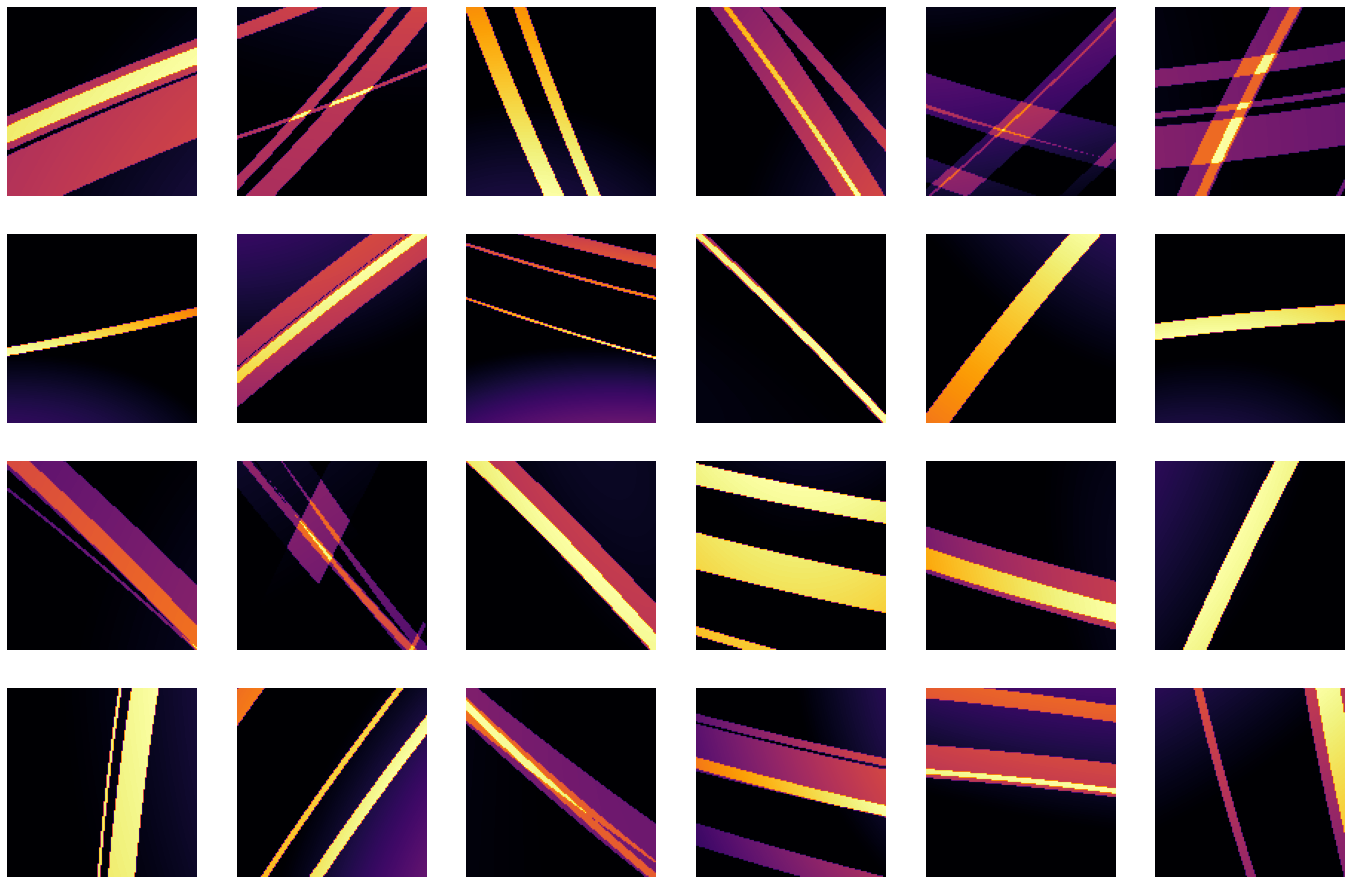

In [22]:
show_images(train_images, 24)

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=inputshape))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [24]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(size//4*size//4*BATCH_SIZE, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((size//4, size//4, BATCH_SIZE)))
    assert model.output_shape == (None, size//4, size//4, BATCH_SIZE) # Note: None is the batch size

    model.add(layers.Conv2DTranspose( BATCH_SIZE//2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, size//4, size//4, BATCH_SIZE//2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(BATCH_SIZE//4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, size//2, size//2, BATCH_SIZE//4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, size, size, 1)

    return model


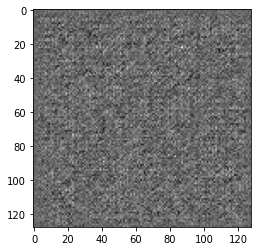

In [25]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [26]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00157245]], shape=(1, 1), dtype=float32)


In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [33]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [34]:
def train(dataset, epochs):
    pbar = tqdm(total=epochs)
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        pbar.update(1)    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [37]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='inferno')
        plt.axis('off')

    plt.savefig('Sim gan results2\image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

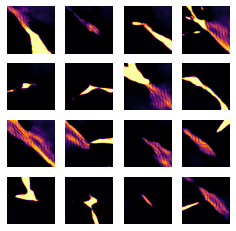

In [38]:
train(train_dataset, EPOCHS)

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [3]:
anim_file = 'Sim gan results2\dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('Sim gan results2\image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


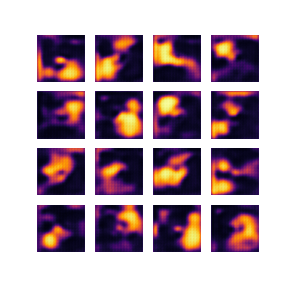

In [4]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)